In [86]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import seaborn as sns
import tqdm

# use white grid
sns.set(style="whitegrid")

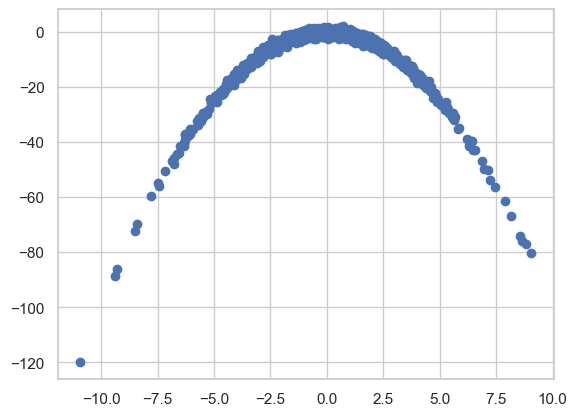

In [87]:
# target distribution q_D
N = 1000
Xs = np.random.randn(2 * N).reshape(N, 2)
Xs[:, 0] *= 3
Xs[:, 1] += -Xs[:, 0] ** 2

plt.figure()
plt.scatter(Xs[:, 0], Xs[:, 1])
plt.show()

In [88]:
# neural network to learn epsilon(x_t,t). you can pla around with it, but we added it for convenience


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(2, 32)
        self.fct = nn.Linear(4, 32)
        self.fc2 = nn.Linear(32, 32)
        self.fc3 = nn.Linear(32, 2)

    def forward(self, x, t):
        # we use a time-embedding here. neural networks are terrible at working directly with time as a real variable.
        # we therefore replace it by a set of features t_embedding that just represent several sine waves with different
        # frequency
        omegas = 2 * np.pi * torch.tensor([1.0 / T, 2.0 / T, 4.0 / T, 8.0 / T]).reshape(1, -1)
        t_embedding = torch.cos(omegas * t.reshape(-1, 1))
        # Network structure: a simple network with two hidden layers. the first
        # two fully connected laers are just there to merge the time embedding with the input vector
        x = F.relu(self.fc1(x) + self.fct(t_embedding))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

#### Task 1: for the given set of T and beta plot the generating distribution q(X_t) for different t=0,30,60,100

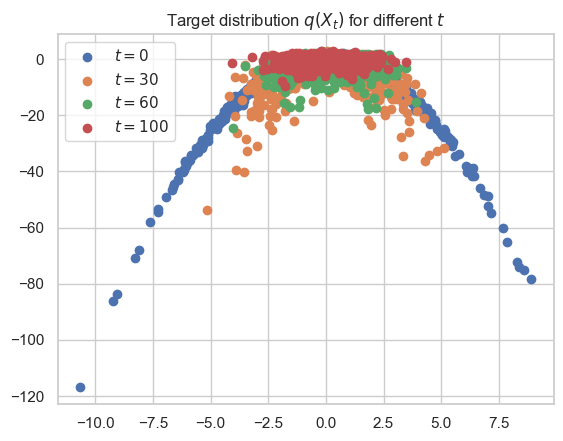

In [100]:
T = 100
betas = 0.05 * np.ones(T)

X_0 = Xs


def alpha(t):
    return np.prod(1.0 - betas[: t + 1])


plt.figure()
plt.title(f"Target distribution $q(X_t)$ for different $t$")
for t in (0, 30, 60, 100):
    X_t = np.random.normal(loc=np.sqrt(alpha(t)) * X_0, scale=1.0 - alpha(t), size=(N, 2))
    plt.scatter(X_t[:, 0], X_t[:, 1], label=f"$t={t}$")
plt.legend()
plt.savefig("results/diffusion_generating_distribution.png")
plt.show()

#### Task 2: implement the loss function for gradient descent (eq 76 in th script, or L_simple in the background material)
implement by sampling a random time step t in 0,..,T

In [90]:
def loss(Xs, model, T, betas):
    """params:
    Xs: a batch of samples from the dataset.
    model: the model for learning epsilon (eps_theta).
    T: maximum time
    betas: array of beta values
    """
    # E_{t,X_0,\epsilon} [||\epsilon - \epsilon_{\theta}(\sqrt{\alpha_t} X_0 + \sqrt{1-\alpha_t} \epsilon, t)||^2]
    # where \alpha_t = \prod_{i=0}^{t-1} (1-\beta_i) and ||.||^2 is the squared euclidean norm
    # We sample from a random time t \in T
    t = torch.randint(0, T, (1,))
    alpha_t = torch.tensor(alpha(t))
    eps = torch.randn_like(Xs)
    Xs_noisy = torch.sqrt(alpha_t) * Xs + torch.sqrt(1.0 - alpha_t) * eps
    eps_pred = model(x=Xs_noisy, t=t)
    return torch.mean((eps - eps_pred) ** 2)

In [91]:
# train loop. added for your convenience.
train_loader = torch.utils.data.DataLoader(torch.tensor(Xs, dtype=torch.float32), batch_size=10)
model = Net()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
model.train()
num_epochs = 500
losses = []
for e in tqdm.trange(num_epochs):
    for data in train_loader:
        optimizer.zero_grad()
        l = loss(data, model, T, betas)
        losses.append(l.detach().item())
        l.backward()
        optimizer.step()

  0%|          | 0/500 [00:00<?, ?it/s]

100%|██████████| 500/500 [01:01<00:00,  8.14it/s]


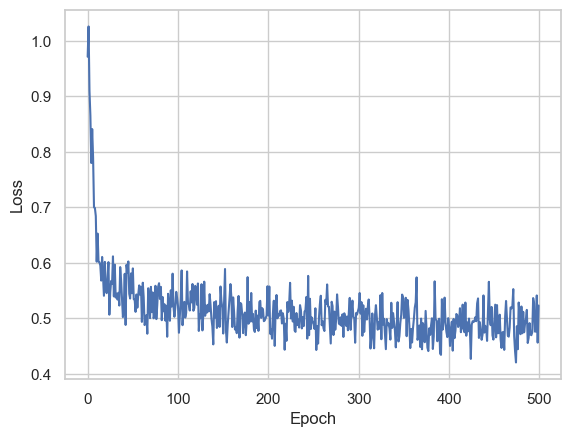

In [97]:
# Plot loss and standard deviation
sns.lineplot(x=range(num_epochs), y=np.array(losses).reshape(num_epochs, -1).mean(axis=1))
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.savefig("results/diffusion_loss.png")

#### Task 3: generate samples from the learned model

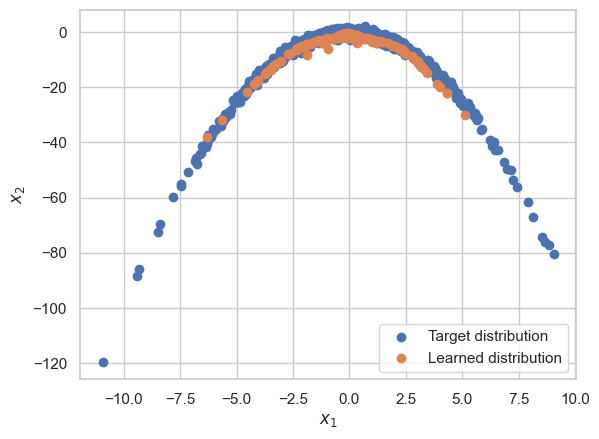

<Figure size 640x480 with 0 Axes>

In [98]:
def generate_samples(model, num, betas):
    # Ggenerate by following the Markov-Chain backwards step by step, using
    # X_{t-1}|X_t \sim N(\mu_theta(X_t, t), \beta_T I_d),
    # where
    # \mu_theta(X_t, t) = 1/\sqrt{1-\beta_t} (X_t-\beta_t/\sqrt{1-\alpha_t} \epsilon_{\theta}(X_t, t))

    betas = torch.tensor(betas)
    Xs = torch.normal(0.0, 1.0, size=(num, 2), dtype=torch.float32)
    for t in range(T - 1, -1, -1):
        alpha_t = torch.tensor(alpha(t))
        t = torch.tensor(t)
        mu = 1.0 / torch.sqrt(1.0 - betas[t]) * (Xs - betas[t] / torch.sqrt(1.0 - alpha_t) * model(Xs, t))
        Xs = torch.normal(mu, betas[T - 1] * torch.eye(num, 2))
    return Xs


with torch.no_grad():
    samples = generate_samples(model, 500, betas).detach().numpy()
    plt.figure()
    plt.scatter(Xs[:, 0], Xs[:, 1], label="Target distribution")
    plt.scatter(samples[:, 0], samples[:, 1], label="Learned distribution")
    plt.xlabel("$x_1$")
    plt.ylabel("$x_2$")
    plt.legend()
    plt.show()
    plt.savefig("results/diffusion_samples.png")